## Inverse rendering from simulated data

This notebook performs the inverse rendering of simulated light intensity measurements. It begins by defining illumination patterns and adding noise to the data to mimic single-photon sensing. The notebook then uses maximum likelihood estimation to extract individual signals from these noisy measurements. Finally, it reconstructs the properties of each point, including range, angle of incidence, and reflectance, by solving a sequence of nonlinear least squares problems.

**Note:** The code provided in this notebook is developed specifically for the research presented in the article *Simulation of ultrafast structured illumination in single-photon sensitive single-pixel lidar*. For additional details, please refer to the article or contact the authors.

### Required libraries
This notebook uses the following libraries:

- `matplotlib`
- `numpy`
- `pandas`
- `pickle`
- `scipy`

In [1]:
# Importing necessary libraries

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, ScalarFormatter
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.optimize import minimize
from scipy.integrate import trapz

### Parameters

In [2]:
# Parameters of the measurement setting

wavelength = 1550e-9 # Laser wavelength
divergence = 1e-3 # Divergence half-angle of the cone-shaped beam in radians

# Define parameters for the transmitted power in the time domain
sigma = 0.1e-9  # Standard deviation of the Gaussian pulse (in seconds)
pulse_length = 1e-9  # Duration of the pulse (in seconds)
pulse_energy = 1e-9  # Total energy of the pulse (in joules)

def total_power(t):
    """
    Calculate the transmitted power of the beam at time t.

    Parameters:
    t (float): The time at which to evaluate the transmitted power.

    Returns:
    float: The power of the beam at time t.
    """
    return (pulse_energy / (np.sqrt(2 * np.pi * sigma**2))) * \
           np.exp(-0.5 * (t - pulse_length / 2)**2 / sigma**2)

# Parameters of the detector setup
sampling_rate = 20e9   # Sampling rate in measurements per second
diameter = 5e-2        # Diameter of the circular detector aperture in meters
detector_area = np.pi * (diameter**2) / 4  # Area of the circular detector aperture in square meters

### Load data

In [3]:
with open('ray_tracing_data', 'rb') as file:
    data = pickle.load(file)

### Hadamard imaging basis

In [4]:
def hadamard_matrix(n):
    """
    Construct a Hadamard matrix of order n using Sylvester's construction.

    Parameters:
    -----------
    n : int
        The order of the Hadamard matrix. It must be a positive integer that is 
        a power of 2.

    Returns:
    --------
    numpy.ndarray
        The Hadamard matrix of order n.

    Raises:
    -------
    ValueError
        If n is not a power of 2 or is less than 1.

    Notes:
    -------
    - Sylvester's construction starts with the base case of a 1x1 Hadamard matrix 
      and recursively builds larger matrices by combining smaller ones.
    """

    # Check if n is a positive integer and a power of 2
    if n <= 0 or (n & (n - 1)) != 0:
        raise ValueError("The order n must be a positive power of 2.")

    if n == 1:
        # Base case: 1x1 Hadamard matrix
        return np.array([[1]])
    else:
        # Recursive case: Construct the Hadamard matrix of order n
        H_half = hadamard_matrix(n // 2)
        H = np.block([[H_half, H_half], [H_half, -H_half]])
        return H


In [5]:
# Constructing the Hadamard imaging basis matrix

n = len(data) # Number of illumination elements

H = hadamard_matrix(n) # Hadamard matrix of order n

# Cosntruct the Hadamard imaging basis matrix and remove the zero row
Hplus = (H+np.ones(H.shape))/2
Hminus = (np.ones(H.shape)-H)/2

B = np.vstack((Hplus, Hminus)) # Basis matrix

# Identify the zero row
zero_rows = np.all(B == 0, axis=1)
zero_row_index = np.where(zero_rows)[0][0]

B = np.delete(B, zero_row_index, axis=0) # Basis matrix without the zero row

In [6]:
# Forming noisy single-pixel measurements

def measurements(B, data, N_samples):
    """
    Simulate noisy single-pixel measurements for each illumination pattern in the basis matrix `B`.

    The function combines individually simulated signals from active laser elements, adds Poisson-distributed
    noise to simulate photon counting, and averages multiple noise samples to estimate the expected photon count.

    Parameters:
    -----------
    B : np.ndarray
        A binary basis matrix of shape (n_patterns, n_elements) where each row defines an illumination pattern.
        '1' indicates an active laser element, '0' indicates an inactive element.
    data : list of dict
        List of dictionaries containing the simulated data for each laser element.
    N_samples : int
        The number of Poisson noise samples to generate for each pattern, used to estimate the mean photon count.

    Returns:
    --------
    measurements : list of np.ndarray
        A list of noisy intensity measurements for each illumination pattern. Each element in the list
        corresponds to the measured intensity signal for a given pattern, after adding noise and averaging.
    """
    # Initialise the list to store measurements for each pattern
    measurements = []

    # Loop through each illumination pattern in the basis matrix B
    for i in range(B.shape[0]):
        # Initialise the intensity signal for the i-th pattern
        intensities = np.zeros(data[0]['intensity'].shape)

        # Combine signals from active laser elements (based on the current row of B)
        for j in range(B.shape[1]):  # Loop over all laser elements
            if B[i, j] == 1:  # If element j is active in pattern i
                intensities += data[j]['intensity']  # Add its corresponding intensity signal

        # Calculate the expected photon count from the intensity signal
        expectation = intensities * detector_area * wavelength / (scipy.constants.Planck * scipy.constants.c * sampling_rate)

        # Initialise a sum for the sample mean estimate of the expected photon count
        sample_sum = 0

        # Collect multiple Poisson noise samples and accumulate them to compute the sample mean
        for k in range(N_samples):
            # Simulate photon counting noise using a Poisson distribution
            photon_count = np.random.poisson(expectation)
            
            # Convert the photon count back to a power intensity signal
            noisy_intensity = photon_count * scipy.constants.Planck * scipy.constants.c * sampling_rate / (wavelength * detector_area)
            
            # Accumulate the noisy intensity signal
            sample_sum += noisy_intensity

        # Compute the sample mean and append it as the final measurement for the i-th pattern
        measurements.append(sample_sum / N_samples)

    return np.array(measurements)


### Forward model

This model assumes that the detector is located at the origin.

In [7]:
def model(t, source, alpha, gamma, rho):
    """
    Forward model to calculate the light intensity at time t, measured from a single source, for a target characterised by 
    the parameters alpha, gamma, and rho.

    Parameters:
    -----------
    t : float or np.ndarray
        Time(s) at which to evaluate the model.
    source : np.ndarray
        Coordinates [x0, y0, z0] of the laser source.
    alpha : float
        Slope parameter of the plane in the form z = alpha * x + gamma.
    gamma : float
        Intercept parameter of the plane equation.
    rho : float
        Reflectance of the material (Lambertian reflectance).

    Returns:
    --------
    float or np.ndarray
        The calculated surface integral at time(s) t.
    
    Notes:
    ------
    The function performs numerical integration using the trapezoidal rule. The integrand is based on physical
    principles related to the interaction of Gaussian beams with Lambertian surfaces.
    """
    
    def integrand(u, v, time, source):
        """
        Computes the integrand for the surface integral over the ellipse.

        Parameters:
        -----------
        u : np.ndarray
            Angular coordinate (theta) in polar form, ranging from 0 to 2*pi.
        v : np.ndarray
            Radial coordinate, normalized between 0 and 1.
        time : float
            Time point for evaluating the integrand.
        source : list or np.ndarray
            Coordinates [x0, y0, z0] of the source point in the plane.

        Returns:
        --------
        np.ndarray
            Values of the integrand evaluated at the given u, v, and time.
        """
        x0, y0, _ = source

        # Precompute commonly used terms for performance
        alpha_x0_plus_gamma = alpha * x0 + gamma
        cos_u = np.cos(u)
        sin_u = np.sin(u)
        sqrt_v = np.sqrt(v)

        # Expression simplification for performance
        divisor = 1 / divergence - alpha * cos_u
        expr = sqrt_v * (alpha_x0_plus_gamma) / divisor

        # Calculate point (x, y, z) on the plane
        x = x0 + cos_u * expr
        y = y0 + sin_u * expr
        z = alpha_x0_plus_gamma + sqrt_v * ((alpha_x0_plus_gamma) / (divergence * divisor) - (alpha_x0_plus_gamma))

        # Compute normal vector (n1, 0, n3)
        expression = (alpha_x0_plus_gamma)**2 / (2 * (alpha * divergence * cos_u - 1)**2)
        n1 = alpha * divergence**2 * expression
        n3 = -divergence**2 * expression

        # Beam radius and radial distance
        beam_radius_squared = (divergence * (alpha * x + gamma))**2
        radial_distance_squared = (x - x0)**2 + (y - y0)**2 

        # Total squared distance from source to (x, y, z)
        dist_squared = radial_distance_squared + z**2

        # Calculate the integrand value
        integrand_value = (
            total_power(time - (np.sqrt(dist_squared) + np.sqrt(dist_squared)) / scipy.constants.c)
            / ((1-np.exp(-2))*np.pi**2 * beam_radius_squared * dist_squared)
            * np.exp(-2 * (radial_distance_squared) / beam_radius_squared)
            * rho * (n1 * (x - x0) + n3 * z)**2
            / (np.sqrt(n1**2 + n3**2) * dist_squared)
        )
                
        return integrand_value
    
    # Number of grid points for u and v (trapezoidal rule)
    N = 20

    # Initialise the result
    if np.isscalar(t):
        result = 0
        # Create grid for numerical integration
        u = np.linspace(0, 2 * np.pi, N)
        v = np.linspace(0, 1, N)
        U, V = np.meshgrid(u, v)

        # Perform double integration using trapezoidal rule
        result = np.trapz(np.trapz(integrand(U, V, t, source), v, axis=0), u)
    else:
        result = np.zeros(t.shape)
        # Create grid for numerical integration
        u = np.linspace(0, 2 * np.pi, N)
        v = np.linspace(0, 1, N)
        U, V = np.meshgrid(u, v)

        # Compute result for each time point in t
        for time_index in range(t.shape[0]):
            result[time_index] = np.trapz(np.trapz(integrand(U, V, t[time_index], source), v, axis=0), u)

    return result


### Maximum likelihood estimation

The objective of this process is to minimise the negative log-likelihood function in order to extract individual signals from noisy single-pixel measurements. The noisy photon counts are represented in an $m \times N$ matrix, which is treated as a realisation of a random matrix $\mathcal{Y}$ such that $\mathcal{Y}_{ij} \sim \mathrm{Poisson}\left( (\boldsymbol{BX})_{ij}\right)$. 

Here, $N$ represents the number of time instants in the time grid, $\boldsymbol{B}\in \left\{0, 1\right\}^{m \times n}$ is the imaging basis matrix, and $\boldsymbol{X} \in \mathbb{R}_{\geqslant 0}^{n \times N}$ is the matrix of expected photon counts for the individual signals. The $i$-th row of both $\boldsymbol{Y}$ and $\boldsymbol{X}$ coorresponds to the measurement from the $i$-th illumination pattern, and the $j$-th column corresponds to the measurements at the $j$-th time instant. In practice, the columns of $\boldsymbol{X}$ may be estimated independently of each other.

In [9]:
def negative_log_likelihood(x, y):
    """
    Compute the negative log-likelihood for a Poisson-distributed random vector.
    
    This function calculates the negative log-likelihood of observing data `y`,
    which is assumed to be a realisation of a random vector from a Poisson(Bx) distribution,
    where B is the imaging basis matrix and `x` is the vector of expected photon counts (signal values).

    Parameters:
    -----------
    x : ndarray
        Vector containing the expected signal values (expected photon counts) at the time instant under consideration.
    y : ndarray
        Observed data vector (realisation of the Poisson-distributed random vector).

    Returns:
    --------
    float
        The computed negative log-likelihood value.
    """

    # Compute the modelled photon counts as the dot product of B (imaging basis matrix) and the signal vector x
    modelled_counts = np.dot(B, x)

    # Mask out negative or zero modelled counts to avoid log(0) or negative Poisson rates
    valid_indices = modelled_counts > 0

    # Compute the negative log-likelihood based on the Poisson distribution formula
    return np.sum(modelled_counts[valid_indices] - y[valid_indices] * np.log(modelled_counts[valid_indices]))


In [10]:
def negative_log_likelihood_gradient(x, y):
    """
    Compute the gradient of the negative log-likelihood function.

    This function calculates the gradient for the negative log-likelihood based on the observed data `y` 
    and the expected signals `x`.

    Parameters:
    -----------
    x : ndarray
        Vector containing the expected signal values (expected photon counts) at the time instant under consideration.
    y : ndarray
        Observed data vector (realisation of the Poisson-distributed random vector).

    Returns:
    --------
    ndarray
        The computed gradient of the negative log-likelihood function.
    """

    # Compute the modelled photon counts as the dot product of the basis matrix B and the expected signals X
    modelled_counts = np.dot(B, x)

    # Identify indices where the modelled counts are positive to avoid division by zero
    positive_indices = modelled_counts > 0

    # Initialise the gradient vector
    gradient_vec = np.zeros(y.shape)

    # Compute the contribution to the gradient for positive modelled counts
    gradient_vec[positive_indices] = y[positive_indices] / modelled_counts[positive_indices] - 1

    # Calculate the gradient by taking the dot product with the transpose of the basis matrix B
    gradient = np.dot(B.T, gradient_vec)

    return -gradient  # Return the negative


In [11]:
def negative_log_likelihood_hessian(x, y):
    """
    Compute the Hessian of the negative log-likelihood function.

    This function calculates the Hessian matrix for the negative log-likelihood based on the observed data `y` 
    and the expected signals `x`.

    Parameters:
    -----------
    x : ndarray
        Vector containing the expected signal values (expected photon counts) at the time instant under consideration.
    y : ndarray
        Observed data vector (realisation of the Poisson-distributed random vector).

    Returns:
    --------
    ndarray
        The computed Hessian matrix of the negative log-likelihood function.
    """

    # Compute the modelled photon counts as the dot product of the basis matrix B and the expected signals x
    modelled_counts = np.dot(B, x)

    # Identify indices where the modelled counts are positive to avoid division by zero
    positive_indices = modelled_counts > 0

    # Initialise the diagonal vector for the Hessian
    diag_vec = np.zeros(y.shape)

    # Compute the diagonal elements of the Hessian for positive modelled counts
    diag_vec[positive_indices] = y[positive_indices] / (modelled_counts[positive_indices] ** 2)

    # Compute the Hessian matrix using the basis matrix B
    hessian_matrix = np.dot(B.T, np.dot(np.diag(diag_vec), B))

    return hessian_matrix  # Return the computed Hessian matrix


In [12]:
def estimate_signals(measurements):
    """
    Estimate individual signals from single-pixel photon count measurements using maximum likelihood estimation.

    This function converts the measured intensities to photon counts and solves for the individual signal values 
    corresponding to each measurement. It employs a maximum likelihood estimation approach to restore the 
    individual signals from the measured data.

    Parameters:
    -----------
    measurements : ndarray
        An array of measured photon counts (intensities) from single-pixel measurements.

    Returns:
    --------
    ndarray
        An array of estimated individual signals corresponding to the input measurements.
    """

    # Convert intensity measurements to photon counts
    photon_counts = measurements * wavelength / (scipy.constants.c * scipy.constants.Planck) * detector_area / sampling_rate

    # Include the 'zero pattern' in the Hadamard basis matrix for the initial guess
    measurements_with_zero = np.vstack((np.vstack((photon_counts[0:zero_row_index], np.zeros(photon_counts[0].shape))), photon_counts[zero_row_index:]))
    y = np.dot(np.hstack((np.eye(B.shape[1]), -np.eye(B.shape[1]))), measurements_with_zero)
    
    # Compute the inverse of the Hadamard matrix
    inverse_matrix = H.T / H.shape[0]
    initial_guess = np.dot(inverse_matrix, y)

    # Reshape initial guess if necessary
    if initial_guess.ndim == 1:
        initial_guess = initial_guess.reshape((1, -1))

    # Initialize a list to store the solved signals
    estimated_signals = []

    # Iterate over each measurement to solve for individual signals
    for j in range(measurements.shape[1]):
        x0 = initial_guess[:, j]
        result = minimize(
            negative_log_likelihood,
            x0,
            args=(photon_counts[:, j],),
            method='Newton-CG',
            jac=negative_log_likelihood_gradient,
            hess=negative_log_likelihood_hessian
        )
        estimated_signal = result.x
        estimated_signals.append(estimated_signal)

    # Convert the list of estimated signals to an array and transpose it
    estimated_signals = np.array(estimated_signals).T

    # Convert the estimated signals back to the original units
    return estimated_signals * scipy.constants.c * scipy.constants.Planck / (wavelength * detector_area) * sampling_rate


### Inverse rendering

In [13]:
def solve(spi_data):
    """
    Inverse rendering to estimate parameters for individual signals from SPI data.

    This function first estimates the individual signals from the given SPI measurements.
    Then, for each signal, it uses a nonlinear least squares optimisation to determine the
    parameters (alpha, gamma, and rho) that best fit the predicted signal from the model.

    Parameters:
    -----------
    spi_data : ndarray
        The single-pixel intensity measurements used to estimate the individual signals.

    Returns:
    --------
    results : list of list
        A list containing the estimated parameters [alpha, gamma, rho] for each signal.
    """
    # Extract the time stamps from the data
    ts = data[0]['ts']

    # Estimate individual signals from the SPI data
    signals = estimate_signals(spi_data)

    def residual(params, t, source, observed_signal):
        """
        Compute the residuals between the predicted and observed signals.

        Parameters:
        -----------
        params : list
            List containing the parameters [alpha, gamma, rho].
        t : ndarray
            Time stamps for the signals.
        source : np.ndarray
            Coordinates of the source.
        observed_signal : ndarray
            The observed signal to be fitted.

        Returns:
        --------
        ndarray
            The residuals between predicted and observed signals.
        """
        alpha, gamma, rho = params
        predicted_signal = model(t, source, alpha, gamma, rho)
        return predicted_signal - observed_signal

    results = []

    for k in range(len(signals)):
        signal = signals[k]
        index = np.argmax(signal)
        
        # Estimate initial values for the nonlinear least squares problem
        range_estimate = (ts[index] - 0.5 * 1e-9) * 299792458 / 2
        test_values = model(ts, data[k]['source'], 0, range_estimate, 1)
        reflectance_estimate = np.amax(signal) / np.amax(test_values)

        initial_guess = [0, range_estimate, reflectance_estimate]

        # Solve a least squares problem to find the best-fit parameters
        result = scipy.optimize.least_squares(residual, initial_guess, args=(ts, data[k]['source'], signal))
        alpha_opt, gamma_opt, rho_opt = result.x

        # Append the found parameters to results
        results.append([alpha_opt, gamma_opt, rho_opt])

    return results


### Reconstruction

In [14]:
# Construct the SPI measurements (estimated as sample means)

N_samples = 100  # Number of acquisitions

# Generate the data
spi_data = measurements(B, data, N_samples)

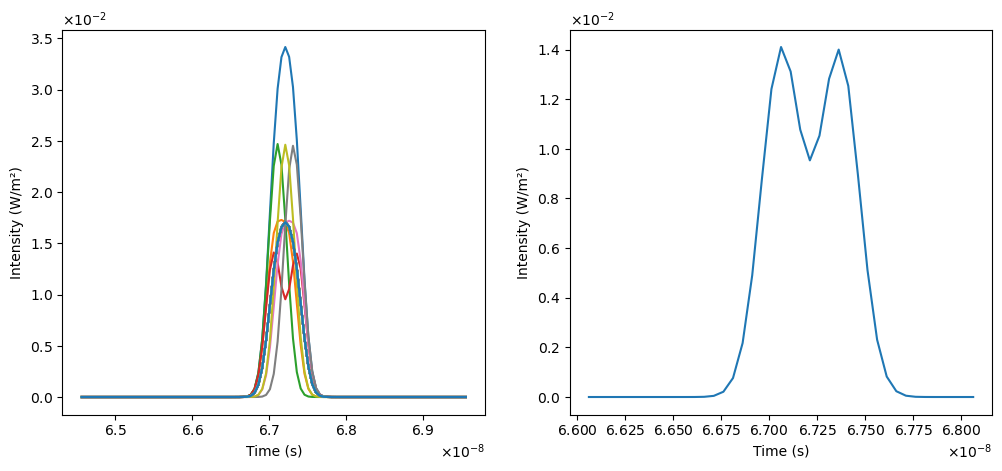

In [15]:
# Visualise the measurements

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ts = data[0]['ts']

for i in range(spi_data.shape[0]):
    intensity = spi_data[i]
    axes[0].plot(ts, intensity)
    
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Intensity (W/m²)')
axes[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

i = 3
intensity = spi_data[i]
index = np.argmax(intensity)
indices = range(index-20, index+21)
axes[1].plot(ts[indices], intensity[indices])

axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Intensity (W/m²)')
axes[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.show()

In [16]:
# Call the 'solve' function to estimate parameters for individual points based on the single-pixel intensity measurements (spi_data).

results = solve(spi_data)

In [17]:
# Construct a DataFrame to present the results of the estimated points

# Initialise a list to store each row of results
df = []

# Loop through each estimated point to populate the DataFrame
for i in range(len(results)):
    # Extract the x-coordinate of the source point
    x0 = data[i]['source'][0]
    
    # Retrieve the estimated parameters: alpha, gamma, and rho
    alpha = results[i][0]  # Angle of incidence slope
    gamma = results[i][1]  # Intercept for the plane equation
    rho = results[i][2]    # Reflectance coefficient

    # Construct a new row with calculated estimates and ground truth values
    new_row = {
        'Point': i + 1,  # Point index 
        'Range estimate (m)': round(alpha * x0 + gamma, 5),  # Estimated range based on alpha and gamma
        'GT range (m)': round(data[i]['range'], 5),  # Ground truth range value
        'Angle of incidence estimate (°)': round(np.abs(np.arctan(alpha)) * 180 / np.pi, 1),  # Estimate in degrees
        'GT angle of incidence (°)': round(np.arccos(data[i]['cosine']) * 180 / np.pi, 1),  # Ground truth angle in degrees
        'Reflectance estimate (%)': round(rho * 100, 1),  # Estimated reflectance percentage
        'GT reflectance (%)': round(data[i]['reflectance'] * 100, 1)  # Ground truth reflectance percentage
    }
    
    # Append the constructed row to the DataFrame list
    df.append(new_row)

# Create a DataFrame from the list of rows
df = pd.DataFrame(df)

# Set 'Point' as the index
df.set_index('Point', inplace=True)

# Center the text in all columns and format numbers
df = df.style.set_properties(**{'text-align': 'center'}) \
    .format({
        'Range estimate (m)': '{:.5f}',
        'GT range (m)': '{:.5f}',
        'Angle of incidence estimate (°)': '{:.1f}',
        'GT angle of incidence (°)': '{:.1f}',
        'Reflectance estimate (%)': '{:.1f}',
        'GT reflectance (%)': '{:.1f}'
    }) \
    .set_table_attributes('style="border-collapse: collapse; border: 1px solid black;"')

In [18]:
# Display the DataFrame

df

,Range estimate (m),GT range (m),Angle of incidence estimate (°),GT angle of incidence (°),Reflectance estimate (%),GT reflectance (%)
Point,,,,,,
1,9.97727,9.97725,44.9,45.0,79.8,80.0
2,9.99242,9.99242,44.9,45.0,79.8,80.0
3,10.00760,10.00758,45.4,45.0,80.7,80.0
4,10.02276,10.02275,45.3,45.0,80.5,80.0
5,9.97728,9.97725,45.1,45.0,80.2,80.0
6,9.99242,9.99242,45.3,45.0,80.5,80.0
7,10.00758,10.00758,44.9,45.0,79.8,80.0
8,10.02276,10.02275,44.9,45.0,79.8,80.0
9,9.97724,9.97725,44.8,45.0,79.7,80.0
